# Random Forest Classification of X-ray Images

This notebook uses scikit-learn random forest to classify X-ray images into good coverage and poor coverage. 

## Import packages, define metrics, prepare datasets

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Matplotlib is building the font cache; this may take a moment.


In [2]:
def countZeroPixels(image):
    """Return the number of value-zero pixels in the image."""
    image=image.flatten()
    return len(image)-np.count_nonzero(image)

def getImageContrast(image):
    """Calculate a simple measure of the image contrast."""
    image=image.flatten()
    image = image[image>0]
    maxp = np.max(image)
    minp = np.min(image)
    return (maxp-minp)/(maxp+minp)

def npixelsAboveNoise(image,threshold=5):
    """Calculate the number pixels above X*sigma of the noise."""
    image=image.flatten()
    image=image[image>0]
    rmsnoise = np.sqrt(np.mean(image**2.))
    return len(image[np.where(image>threshold*rmsnoise)])

def meanSepBrightPixels(image,threshold=5):
    """Return the mean separation (in px) between bright pixels."""
    image=image.flatten()
    image=image[image>0]
    rmsnoise = np.sqrt(np.mean(image**2.))
    sel = np.where(image>threshold*rmsnoise)
    if len(sel[0])==0:
        return 300
    else:
        return (90000/len(image[sel]))**0.5

def medianBrightYPosition(image,threshold=10):
    """Compute the median y-value among bright pixels."""
    rmsnoise = np.sqrt(np.mean(image**2.))
    positions = np.where(image>threshold*rmsnoise)
    return np.median(positions[0])

def medianBrightXPosition(image, threshold=10):
    """Compute the median x-value among bright pixels."""
    rmsnoise = np.sqrt(np.mean(image**2.))
    positions = np.where(image>threshold*rmsnoise)
    return np.median(positions[1])

metadata_funcs = [medianBrightXPosition, medianBrightYPosition, meanSepBrightPixels, npixelsAboveNoise,\
                 getImageContrast, countZeroPixels]

## Metadata proof of concept

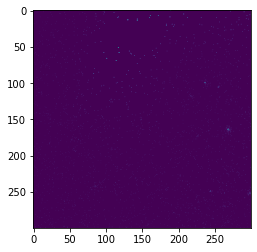

[181.0, 56.0, 86.60254037844386, 12, 0.9245377500197024, 87466]

In [3]:
testimage = fits.open('/srv/scratch/zhutchen/khess_images/poor_coverage/RASS-Int_Hard_grp9530.0_.fits')[0].data

plt.figure()
plt.imshow(testimage)
plt.show()

[fx(testimage) for fx in metadata_funcs]

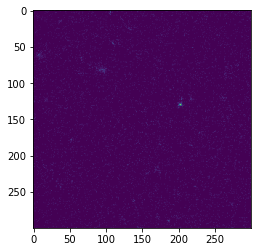

[201.0, 129.0, 134.16407864998737, 5, 0.8627569295942691, 82814]

In [4]:
testimage = fits.open('/srv/scratch/zhutchen/khess_images/nondetections/RASS-Int_Hard_grp10007.0_.fits')[0].data

plt.figure()
plt.imshow(testimage)
plt.show()

[fx(testimage) for fx in metadata_funcs]

# Create training/validation dataset

In [5]:
imagesX = []
labelsy = []

dpath = "/srv/scratch/zhutchen/khess_images/detections/"
for f in os.listdir(dpath):
    if f.endswith('.fits'):
        #imagesX.append(np.array(fits.open(dpath+f)[0].data).flatten())
        image = fits.open(dpath+f)[0].data
        imagesX.append(np.array([fx(image) for fx in metadata_funcs]))
        labelsy.append('good_coverage')

ndpath = "/srv/scratch/zhutchen/khess_images/nondetections/"
for f in os.listdir(ndpath):
    if f.endswith('.fits'):
        #imagesX.append(np.array(fits.open(ndpath+f)[0].data).flatten())
        image = fits.open(ndpath+f)[0].data
        imagesX.append(np.array([fx(image) for fx in metadata_funcs]))
        labelsy.append('good_coverage')

i=0
pcpath = "/srv/scratch/zhutchen/khess_images/poor_coverage_augmented/"
for f in os.listdir(pcpath):
    if f.endswith('.fits') and i>-1:
        #imagesX.append(np.array(fits.open(pcpath+f)[0].data).flatten()) #flatten each 300x300 image to 1x90000
        image = fits.open(pcpath+f)[0].data
        imagesX.append(np.array([fx(image) for fx in metadata_funcs]))
        labelsy.append('poor_coverage')
        i+=1

In [6]:
! ls /srv/scratch/zhutchen/khess_images/poor_coverage_augmented/*.fits | wc -l

3828


In [7]:
labelsy = np.array(labelsy)
imagesX = np.array(imagesX)
print(imagesX.shape)

imagesX, labelsy = shuffle(imagesX, labelsy, random_state=46)

(6574, 6)


^ Shuffle data to ensure no "underlying" distributions.

## Initiate Classifier 

In [8]:
clf = RandomForestClassifier()

## Training the Model

In [9]:
imagesXtrain, imagesXtest, labelsytrain, labelsytest = train_test_split(imagesX, labelsy,\
                                                                        test_size=0.2, random_state=46)

In [11]:
# breakdown valiation sample
print("Percent of poor coverage in training sample: {}".format(len(labelsytrain[labelsytrain=='poor_coverage'])/len(labelsytrain)))
print("Percent of poor coverage in validation sample: {}".format(len(labelsytest[labelsytest=='poor_coverage'])/len(labelsytest)))

Percent of poor coverage in training sample: 0.5888952272295113
Percent of poor coverage in validation sample: 0.555893536121673


In [ ]:
clf.fit(imagesXtrain, labelsytrain)

## Test the results 

In [ ]:
preds = clf.predict(imagesXtest)
print("Accuracy: ", accuracy_score(labelsytest,preds))

## Test individual images

In [ ]:
image = fits.open("/srv/two/zhutchen/rosat_xray_stacker/g3rassimages/eco/RASS-Int_Broad_grp10300_ECO06627.fits")
image = image[0].data
image_metadata = np.array([fx(image) for fx in metadata_funcs]).reshape(1,-1)

plt.figure()
plt.imshow(image)
plt.show()

print(clf.predict_proba(image_metadata))
print(clf.predict(image_metadata))

In [ ]:
image = fits.open("/srv/scratch/zhutchen/khess_images/poor_coverage/RASS-Int_Hard_grp11636.0_.fits")
image = image[0].data
image_metadata = np.array([fx(image) for fx in metadata_funcs]).reshape(1,-1)

plt.figure()
plt.imshow(image)
plt.show()

print(clf.predict_proba(image_metadata))
print(clf.predict(image_metadata))

In [ ]:
image = fits.open("/srv/two/zhutchen/rosat_xray_stacker/g3rassimages/eco/RASS-Int_Soft_grp10003_ECO05407.fits")
image = image[0].data
image_metadata = np.array([fx(image) for fx in metadata_funcs]).reshape(1,-1)

plt.figure()
plt.imshow(image)
plt.show()

print(clf.predict_proba(image_metadata))
print(clf.predict(image_metadata))